In [28]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# set a working directory
wdir = '/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/ASTROCYTE/output/control/'
os.chdir( wdir )

# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'Astrocytes_Control_scenic_integrated-output.loom'

In [30]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.9.1
scanpy      1.9.3
-----
MulticoreTSNE               NA
PIL                         9.5.0
adjustText                  0.8
asttokens                   NA
attr                        23.1.0
backcall                    0.2.0
boltons                     NA
cffi                        1.15.1
cloudpickle                 2.2.1
ctxcore                     0.2.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.1
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
entrypoints                 0.4
executing                   1.2.0
fontTools                   4.39.4
frozendict                  2.3.8
fsspec                      2023.5.0
h5py                        3.8.0
ipykernel                   6.15.0
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
llv

In [31]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [32]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/tmp/ipykernel_3677117/37080085.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [33]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Celltype_Garnett, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Celltype_Garnett',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI']

In [34]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [35]:
lf.close()


In [36]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [37]:
df_motifs = load_motifs('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/ASTROCYTE/output/control/control_reg.csv')


In [38]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

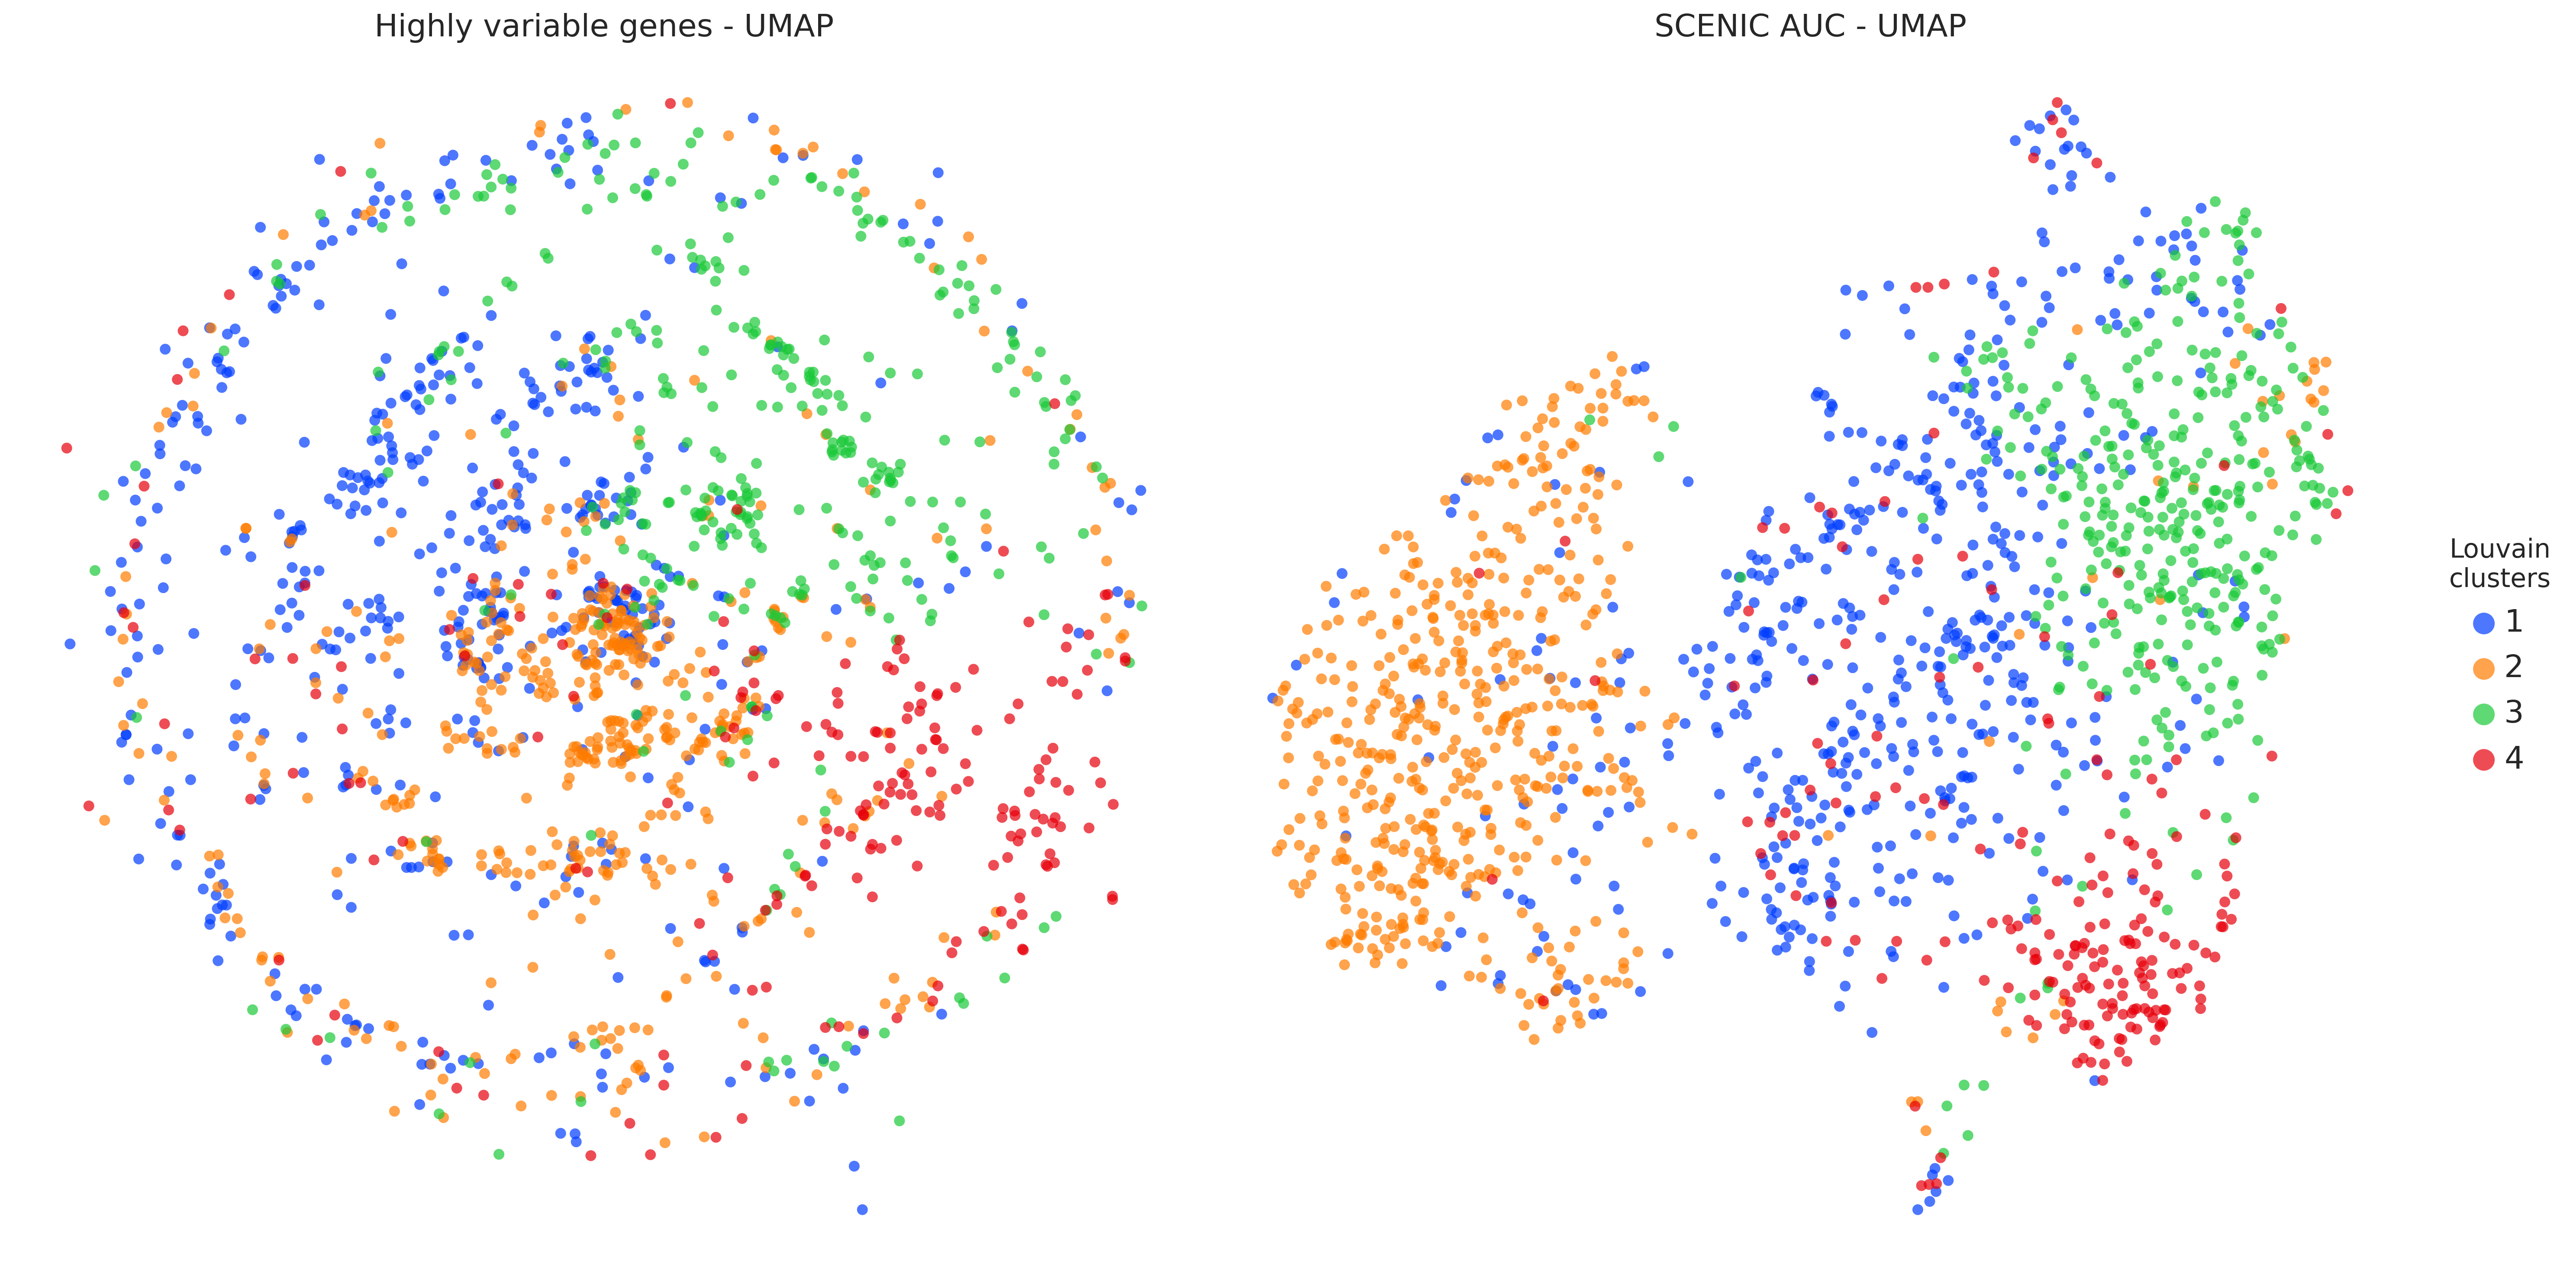

In [39]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("Astrocytes_control_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

# Regulon Specificity Scores (RSS) across predicted cell types

In [40]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [41]:
# calculate RSS
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Celltype_Garnett'] )
rss_cellType

Adf1_(+)  Atf3_(+)  BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  \
Astrocytes  0.191645  0.831765     0.868892     0.851332    0.726994   

            CG4360_(+)  CG5641_(+)   Cf2_(+)  CrebA_(+)   Dif_(+)  ...  \
Astrocytes    0.815376    0.754246  0.824336   0.403135  0.360372  ...   

            luna_(+)  maf-S_(+)  mirr_(+)   nej_(+)   pho_(+)  scro_(+)  \
Astrocytes  0.848948   0.787024  0.713918  0.845219  0.511456  0.819005   

             tgo_(+)   usp_(+)   vvl_(+)  zfh2_(+)  
Astrocytes  0.409536  0.238493  0.844011  0.853276  

[1 rows x 66 columns]

In [42]:
rss_cellType.to_csv(("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/ASTROCYTE/output/control/control_rss_cellType.csv"))

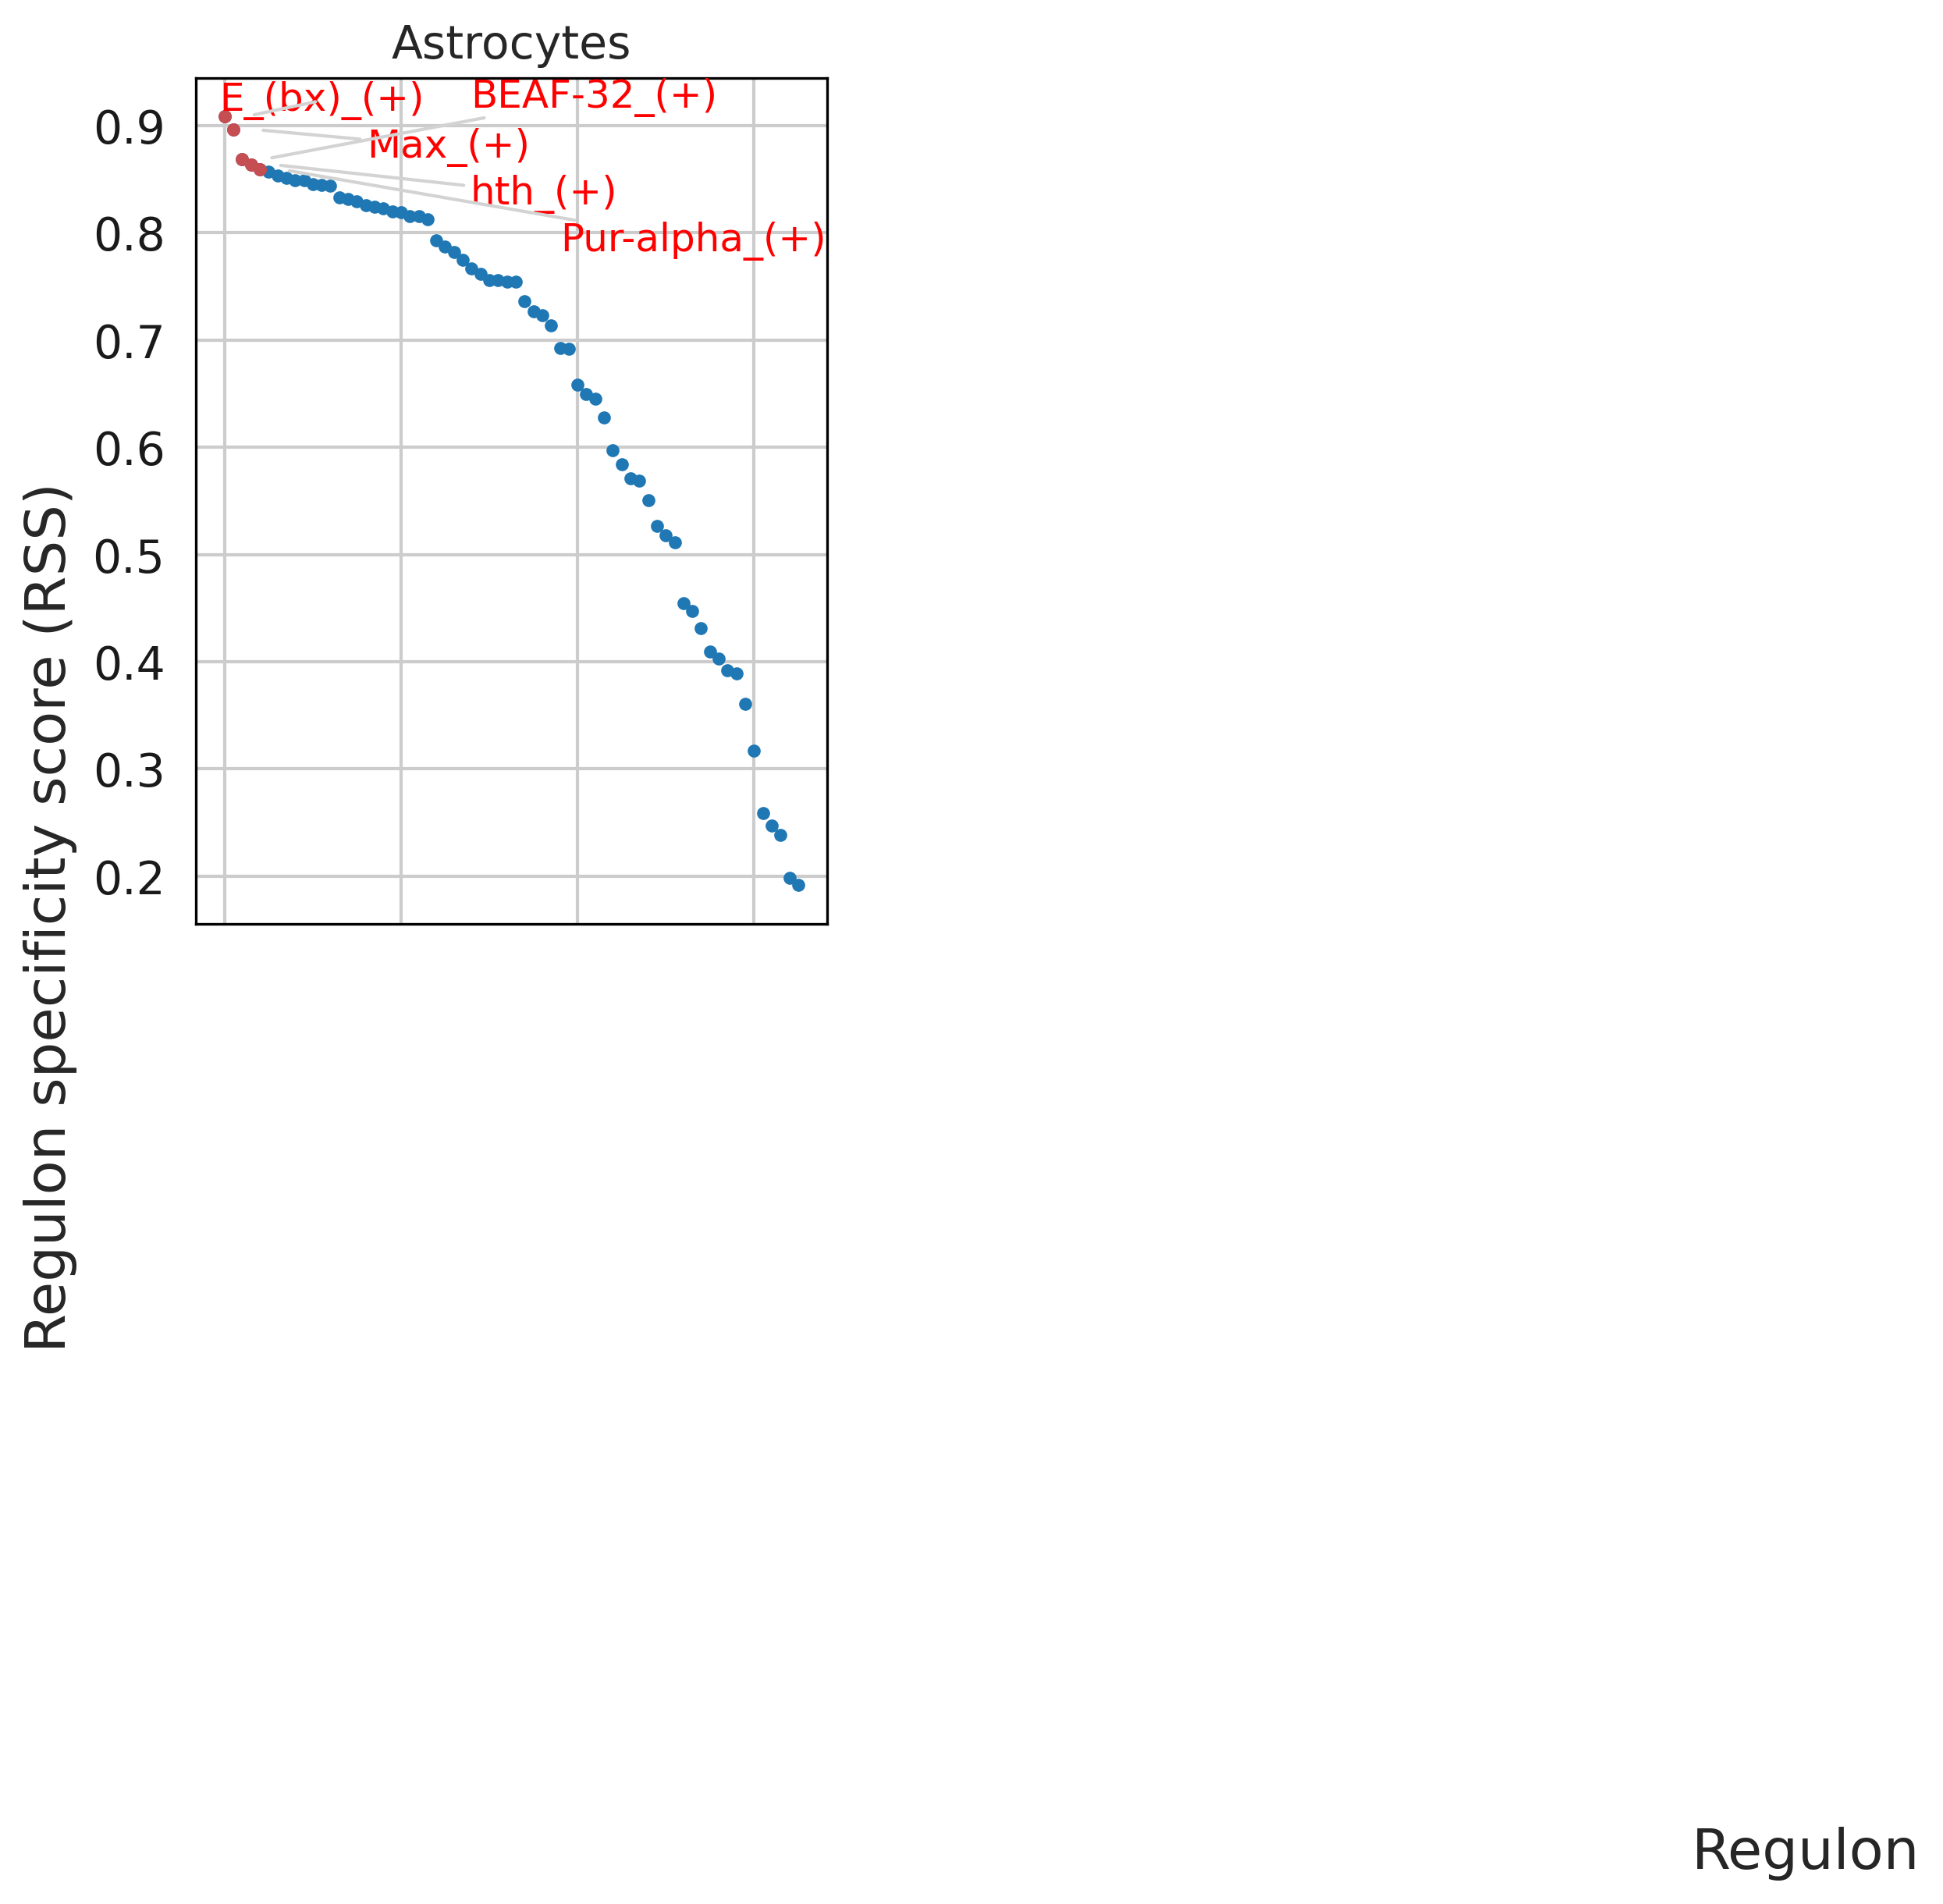

In [43]:
# RSS Panel Plot
cats = sorted(list(set(cellAnnot['Celltype_Garnett'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("Astrocytes_Control_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [44]:
# Select the top 5 regulons
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [45]:
# generate Z score for each regulon 
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [46]:
# generate a heatmap 

def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [47]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype_Garnett'] ]

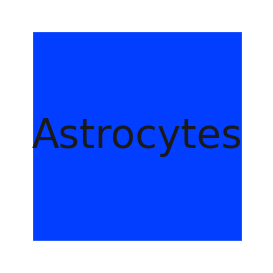

In [48]:

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("Astrocyte_Control_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

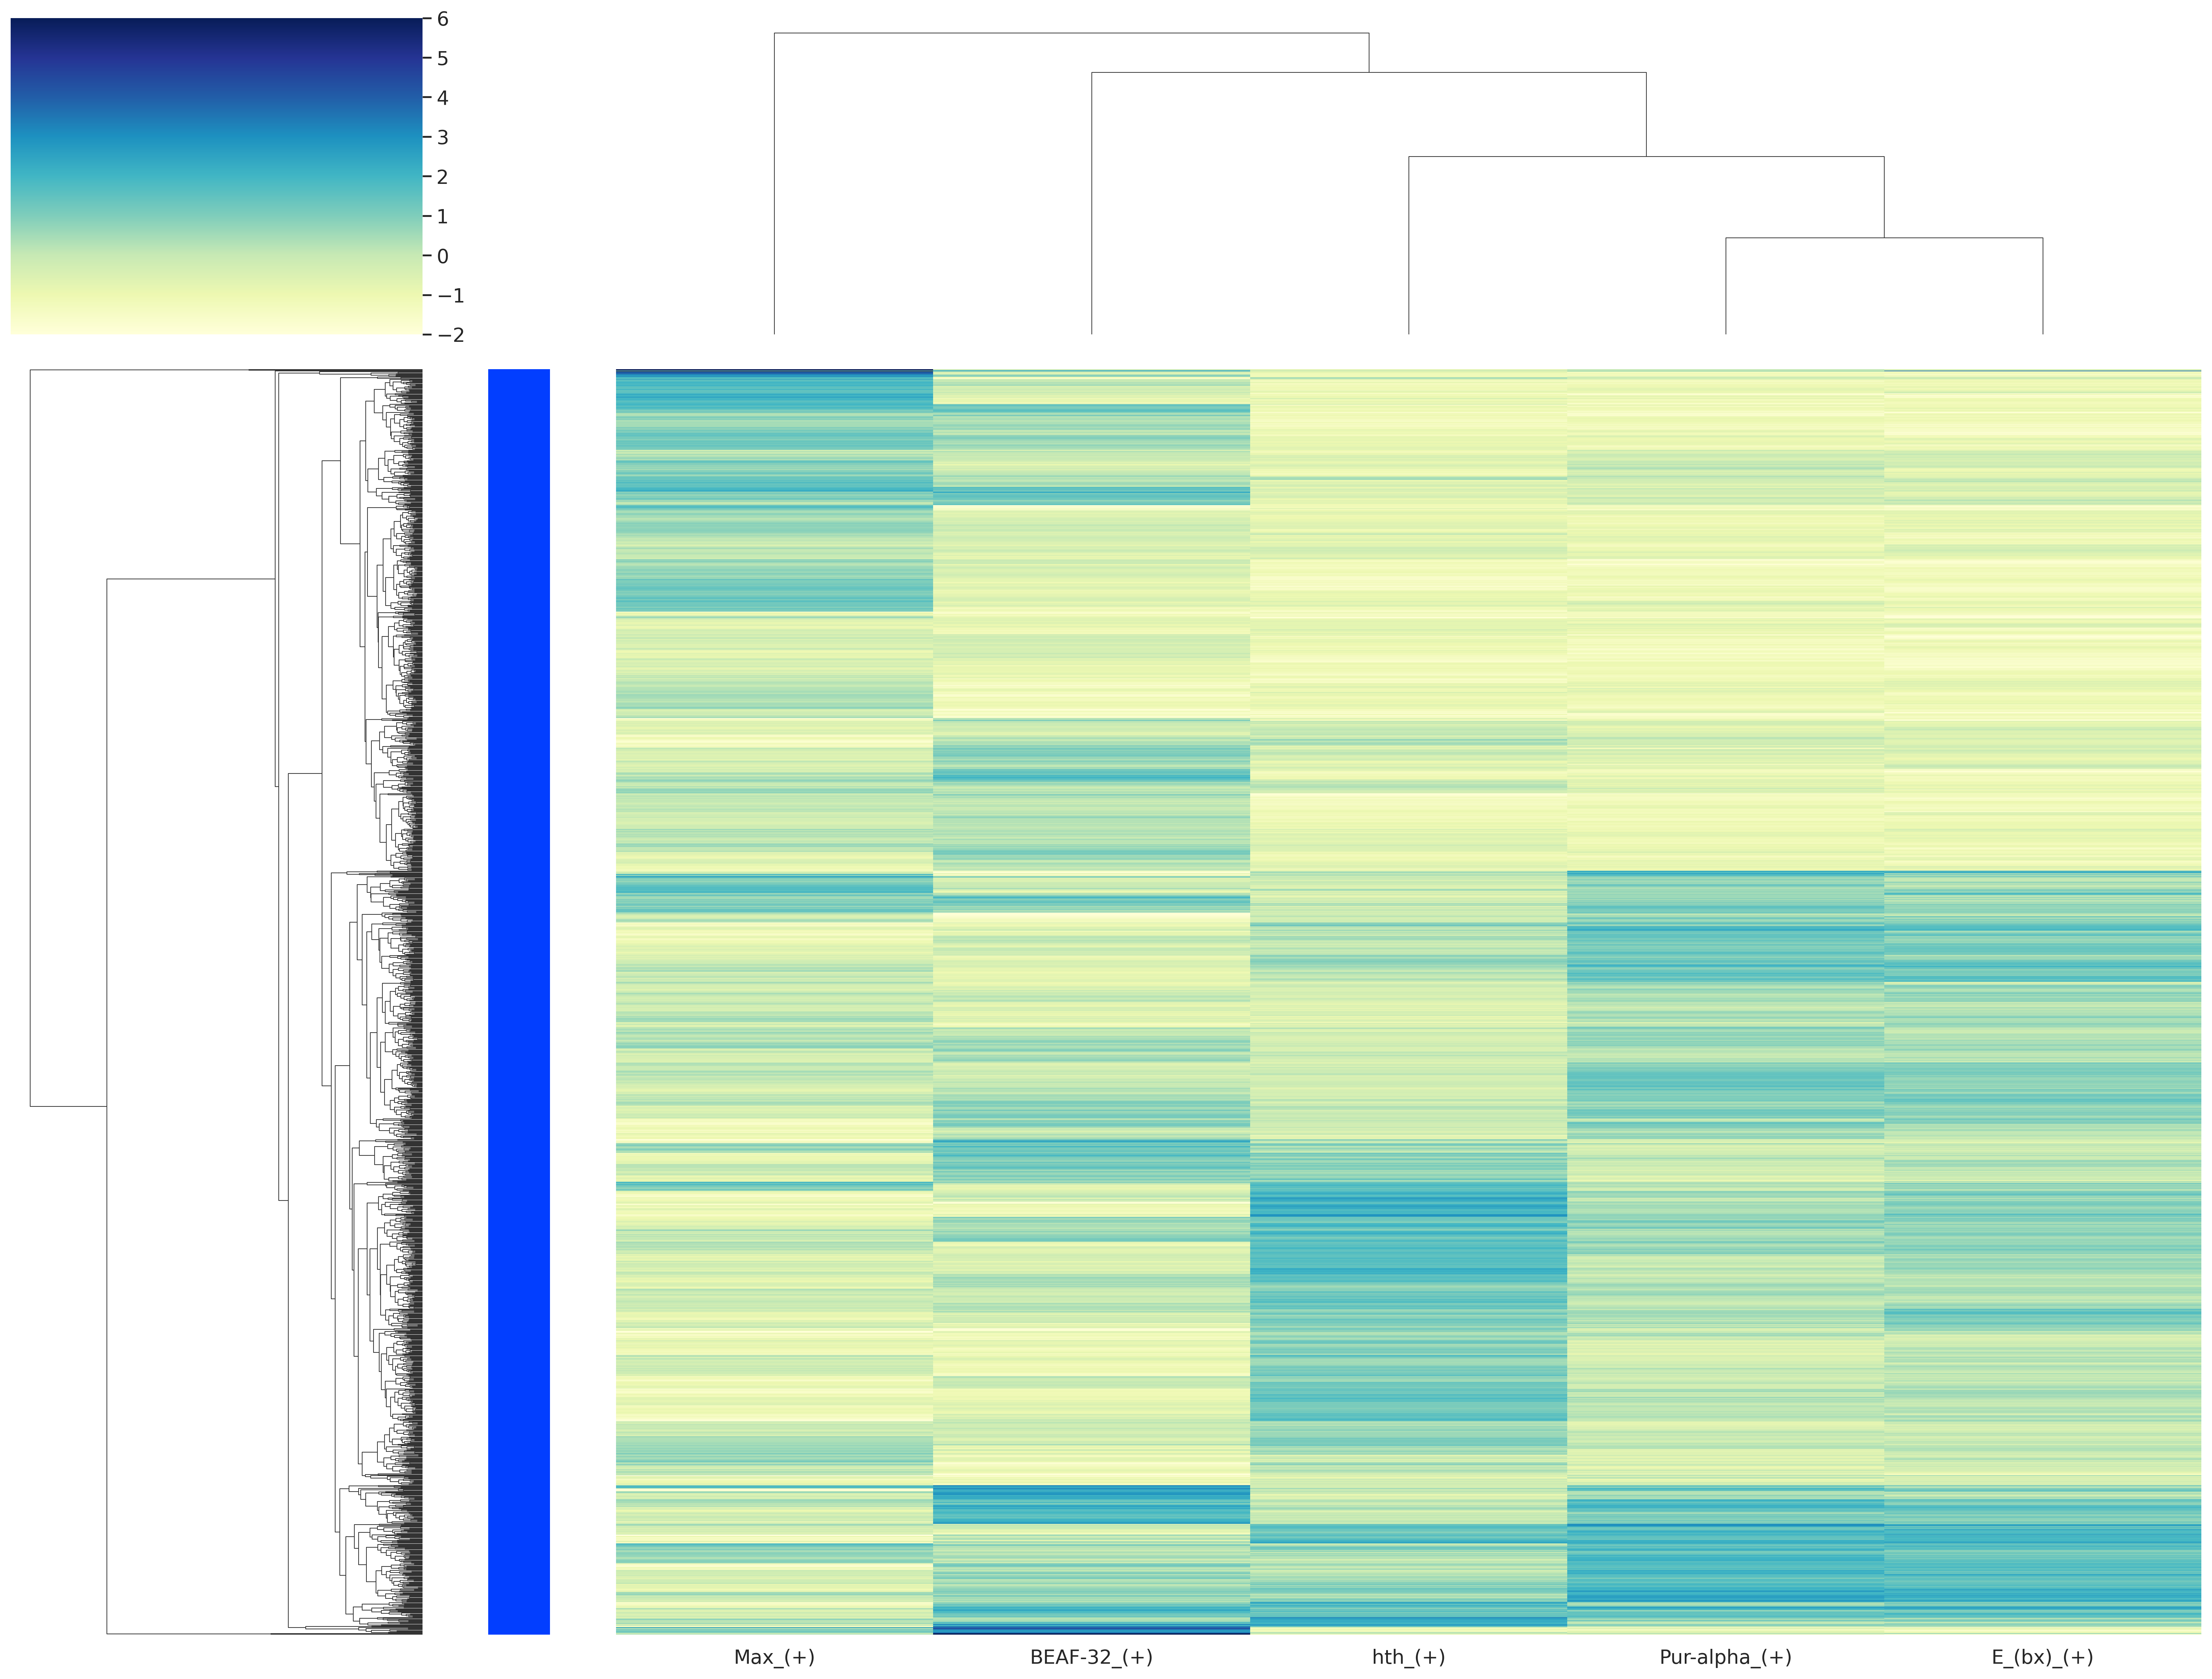

In [49]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("Astrocytes_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [50]:
# generate binary regulon activity matrix
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

Adf1_(+)  Atf3_(+)  BEAF-32_(+)  Blimp-1_(+)  \
AAACGCTAGATGGCAC-1_1         0         0            0            0   
AAAGAACTCCAAGGGA-1_1         0         0            0            0   
AAAGGGCGTGAATGTA-1_1         0         1            0            0   
AACCATGTCACGTCCT-1_1         0         0            0            0   
AACGGGAAGTGGCCTC-1_1         0         0            0            0   

                      BtbVII_(+)  CG4360_(+)  CG5641_(+)  Cf2_(+)  CrebA_(+)  \
AAACGCTAGATGGCAC-1_1           0           0           0        0          0   
AAAGAACTCCAAGGGA-1_1           1           0           0        0          0   
AAAGGGCGTGAATGTA-1_1           0           0           0        0          0   
AACCATGTCACGTCCT-1_1           0           0           0        0          0   
AACGGGAAGTGGCCTC-1_1           0           0           0        0          0   

                      Dif_(+)  ...  luna_(+)  maf-S_(+)  mirr_(+)  nej_(+)  \
AAACGCTAGATGGCAC-1_1        0  ...         1          0         0        0   
AAAGAACTCCAAGGGA-1_1        1  ...         1          0         0        0   
AAAGGGCGTGAATGTA-1_1        1  ...         1          0         0        0   
AACCATGTCACGTCCT-1_1        0  ...         1          0         0        0   
AACGGGAAGTGGCCTC-1_1        1  ...         1          0         0        0   

                      pho_(+)  scro_(+)  tgo_(+)  usp_(+)  vvl_(+)  zfh2_(+)  
AAACGCTAGATGGCAC-1_1        0         0        0        0        0         1  
AAAGAACTCCAAGGGA-1_1        1         0        0        0        0         1  
AAAGGGCGTGAATGTA-1_1        1         0        0        0        0         1  
AACCATGTCACGTCCT-1_1        0         0        0        0        0         1  
AACGGGAAGTGGCCTC-1_1        1         0        0        0        0         1  

[5 rows x 66 columns]

/tmp/ipykernel_3677117/617651963.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/tmp/ipykernel_3677117/617651963.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/tmp/ipykernel_3677117/617

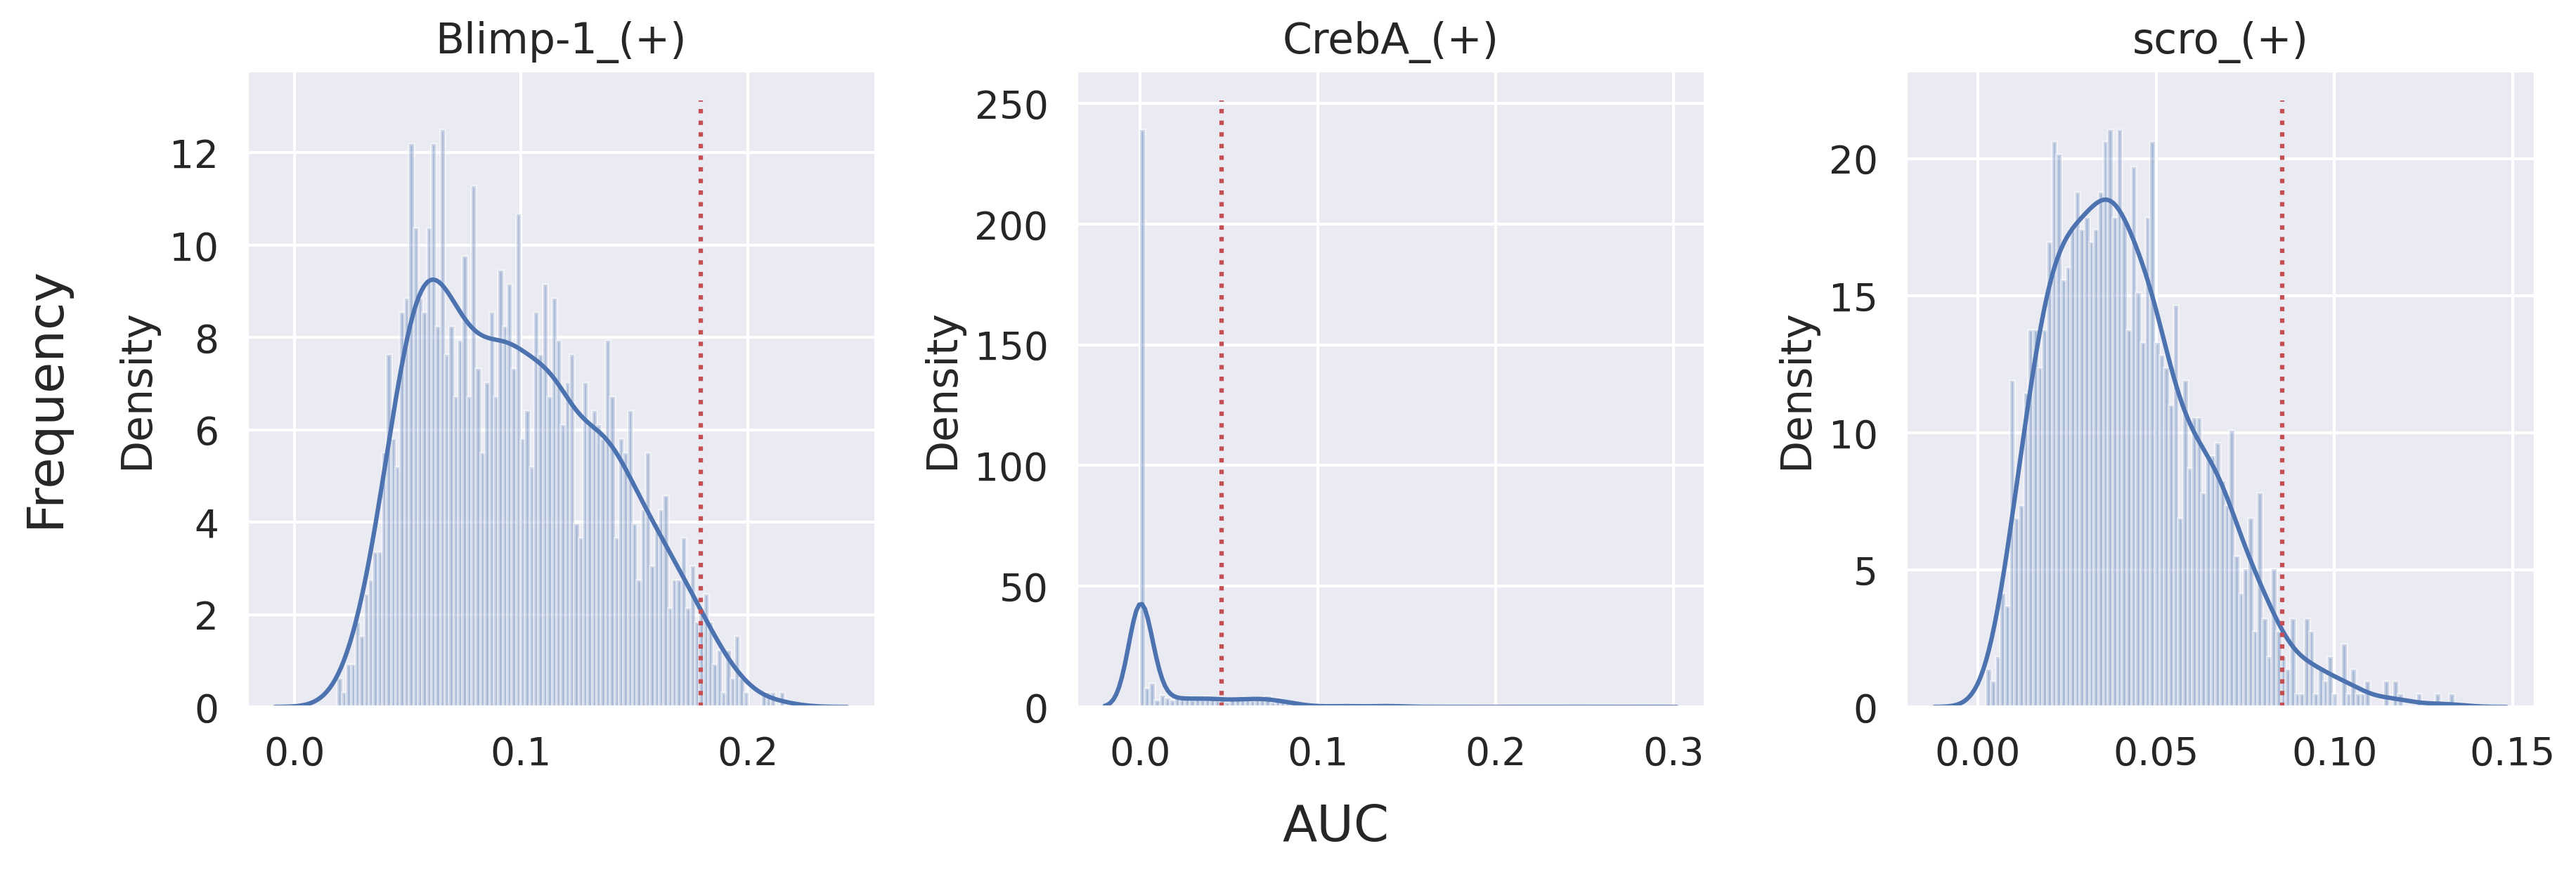

In [51]:
# Show the Auc Distrbutions
# select regulons:
r = [ 'Blimp-1_(+)', 'CrebA_(+)', 'scro_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('Astrocyte_Control_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

# Regulon specificity scores (RSS) across Louvain clusters

In [52]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot['Louvain_clusters_Scanpy'] )
rss_louvain

Adf1_(+)  Atf3_(+)  BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG4360_(+)  \
3  0.190678  0.427209     0.352835     0.407032    0.314983    0.388316   
2  0.184211  0.369381     0.443099     0.450277    0.547252    0.452837   
4  0.186180  0.319042     0.286304     0.307443    0.258789    0.293279   
1  0.181589  0.390978     0.417165     0.346258    0.326308    0.355408   

   CG5641_(+)   Cf2_(+)  CrebA_(+)   Dif_(+)  ...  luna_(+)  maf-S_(+)  \
3    0.338509  0.366545   0.328464  0.294659  ...  0.380425   0.306122   
2    0.432660  0.490752   0.268854  0.271976  ...  0.493913   0.436542   
4    0.271668  0.283625   0.239599  0.224127  ...  0.291660   0.285059   
1    0.402921  0.351286   0.294458  0.276207  ...  0.341053   0.437347   

   mirr_(+)   nej_(+)   pho_(+)  scro_(+)   tgo_(+)   usp_(+)   vvl_(+)  \
3  0.309307  0.357199  0.267253  0.359965  0.271315  0.221589  0.446549   
2  0.529775  0.517992  0.420904  0.508350  0.311350  0.231454  0.400273   
4  0.242915  0.285001  0.260855  0.278713  0.245634  0.192533  0.293688   
1  0.347539  0.344035  0.310499  0.344292  0.304024  0.201289  0.368701   

   zfh2_(+)  
3  0.389848  
2  0.479296  
4  0.298585  
1  0.342012  

[4 rows x 66 columns]

In [53]:
rss_louvain.to_csv("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/ASTROCYTE/output/control/control_rss_louvain.csv")

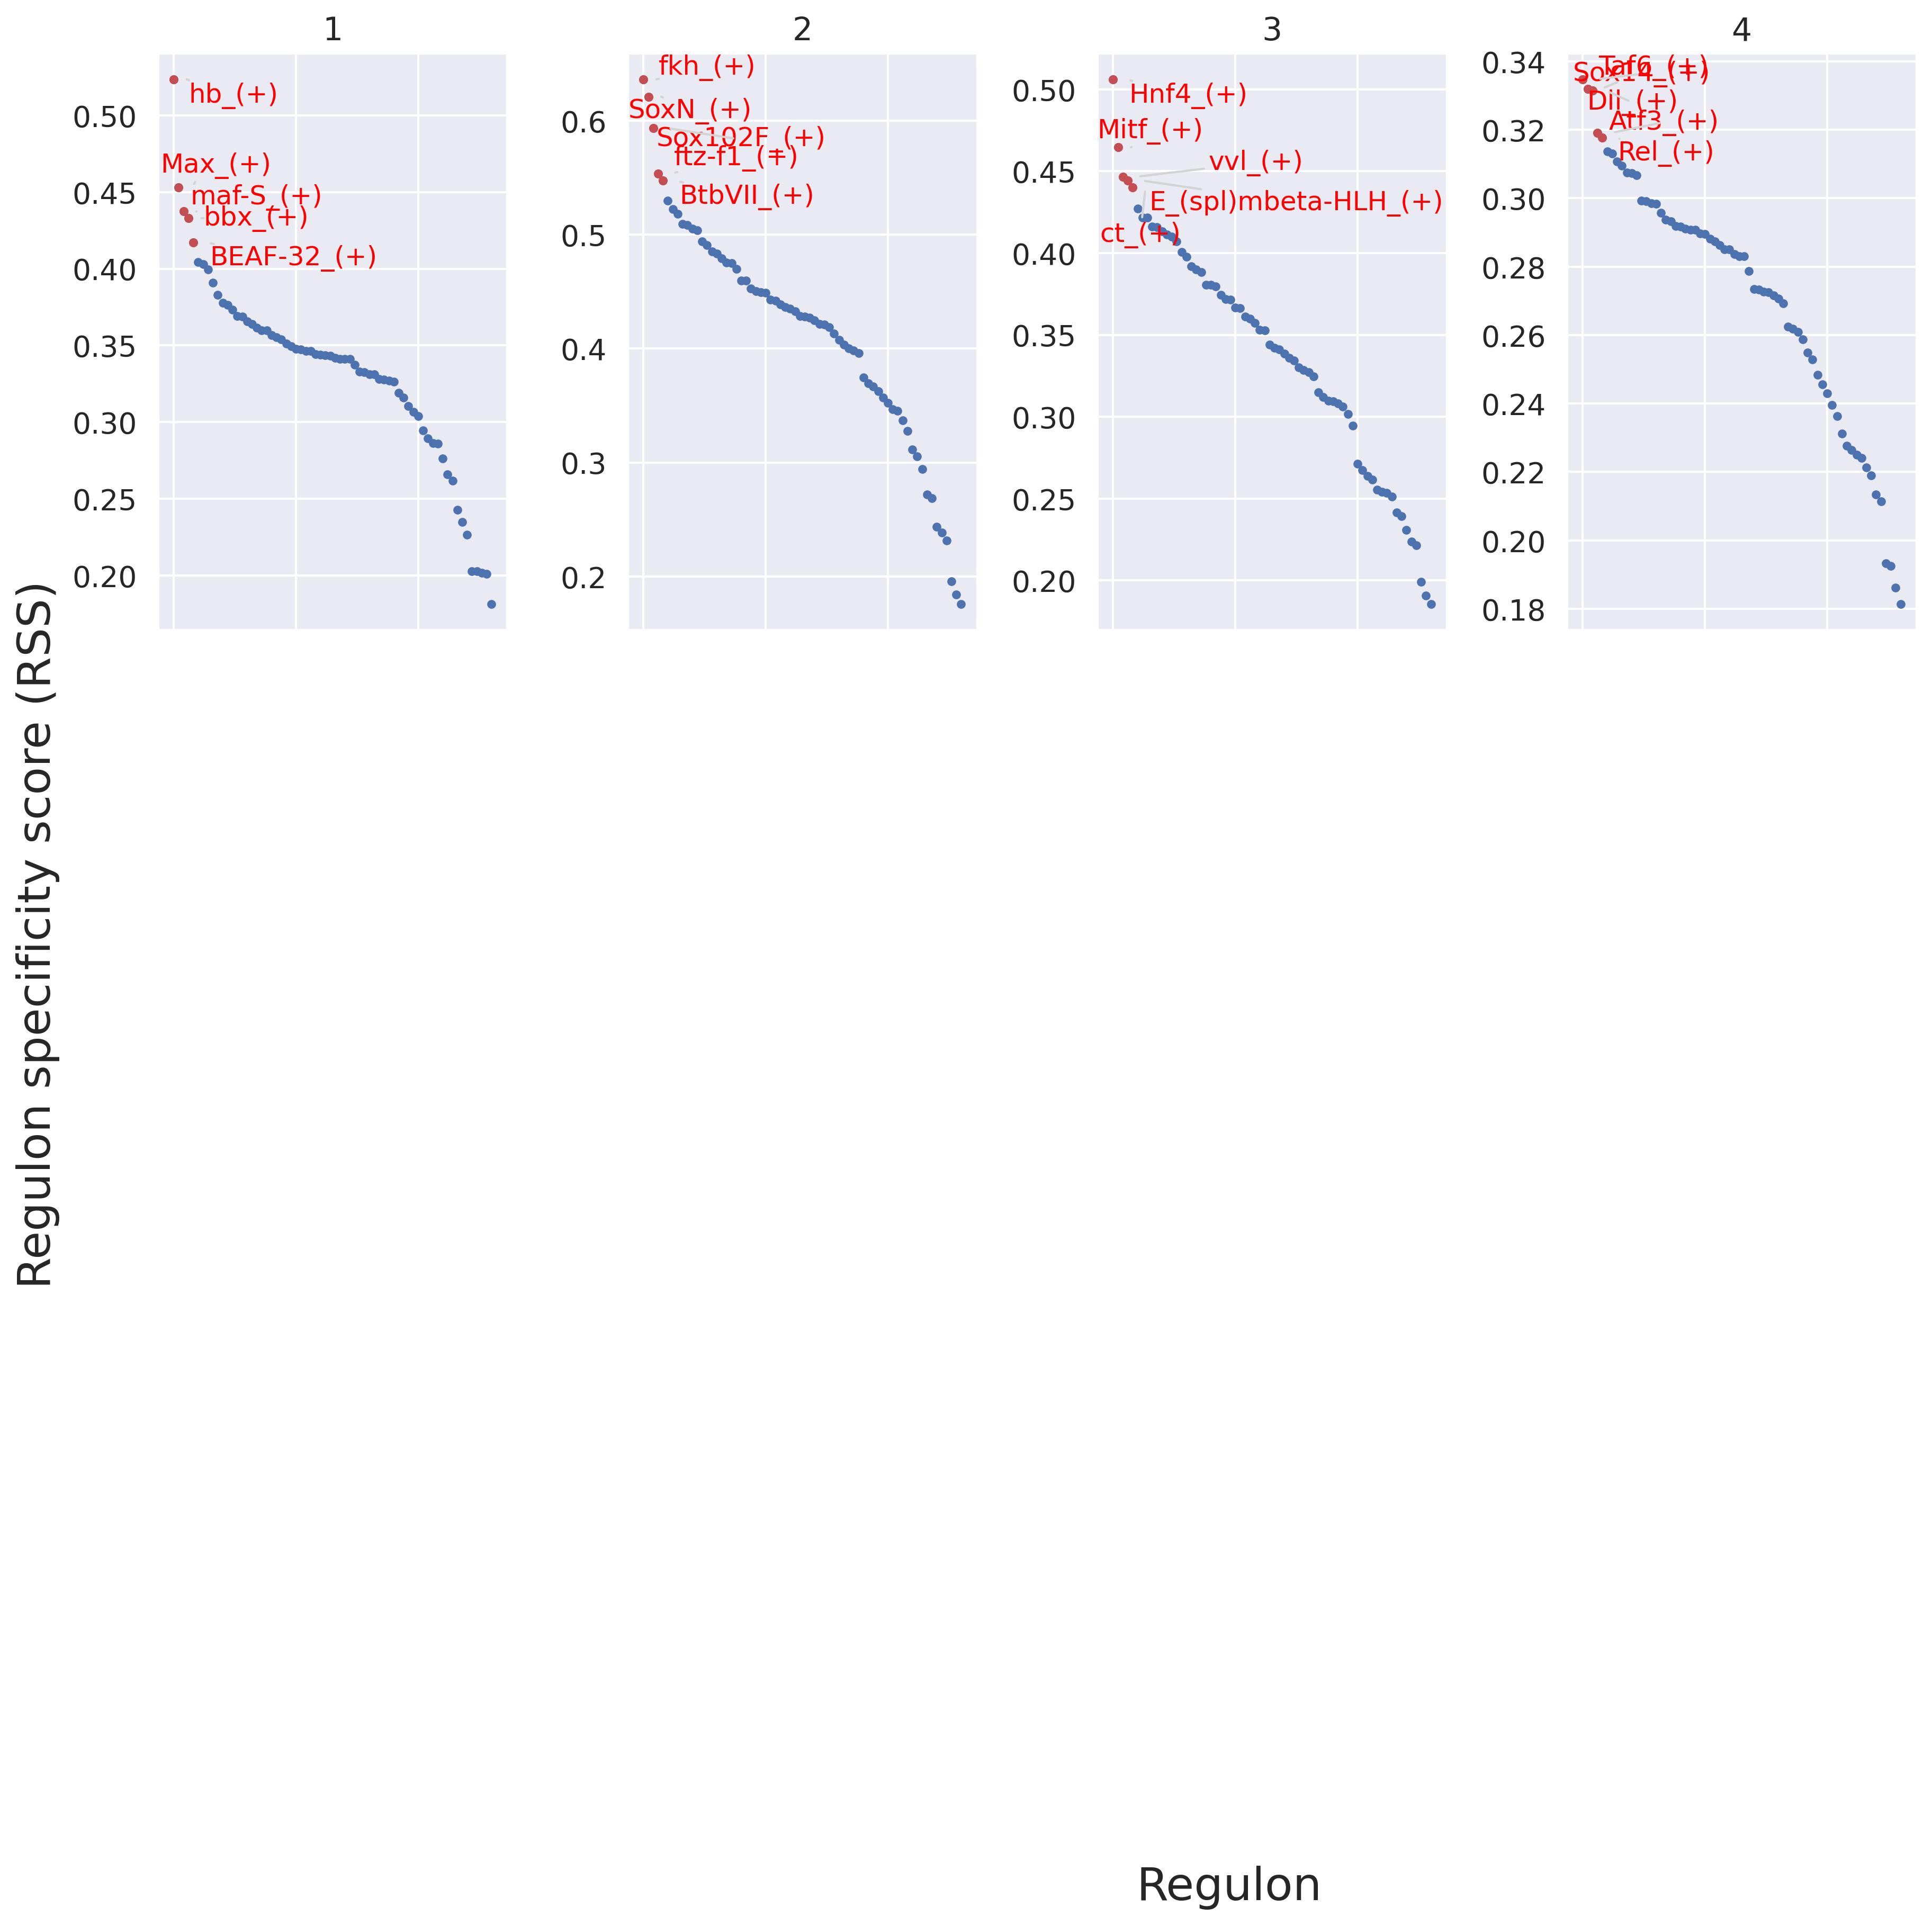

In [54]:
# RSS Panel Plot 
cats = sorted( list(set(cellAnnot['Louvain_clusters_Scanpy'])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("Astrocyte_Control_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

In [55]:
# top 5
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [56]:
# heat map 
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [57]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Louvain_clusters_Scanpy'] ]

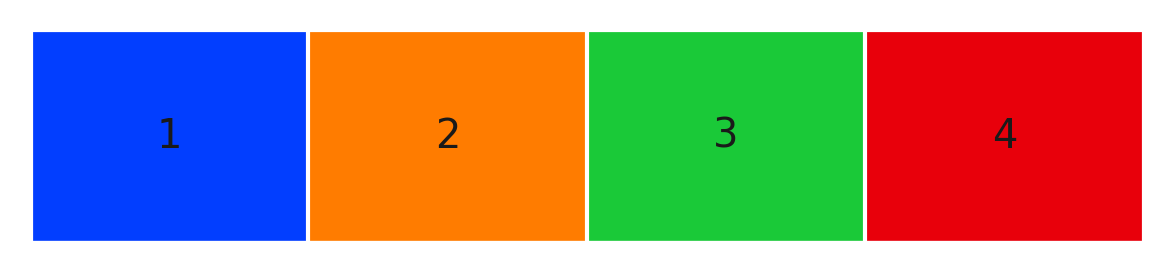

In [58]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -256.43333333333334, '')

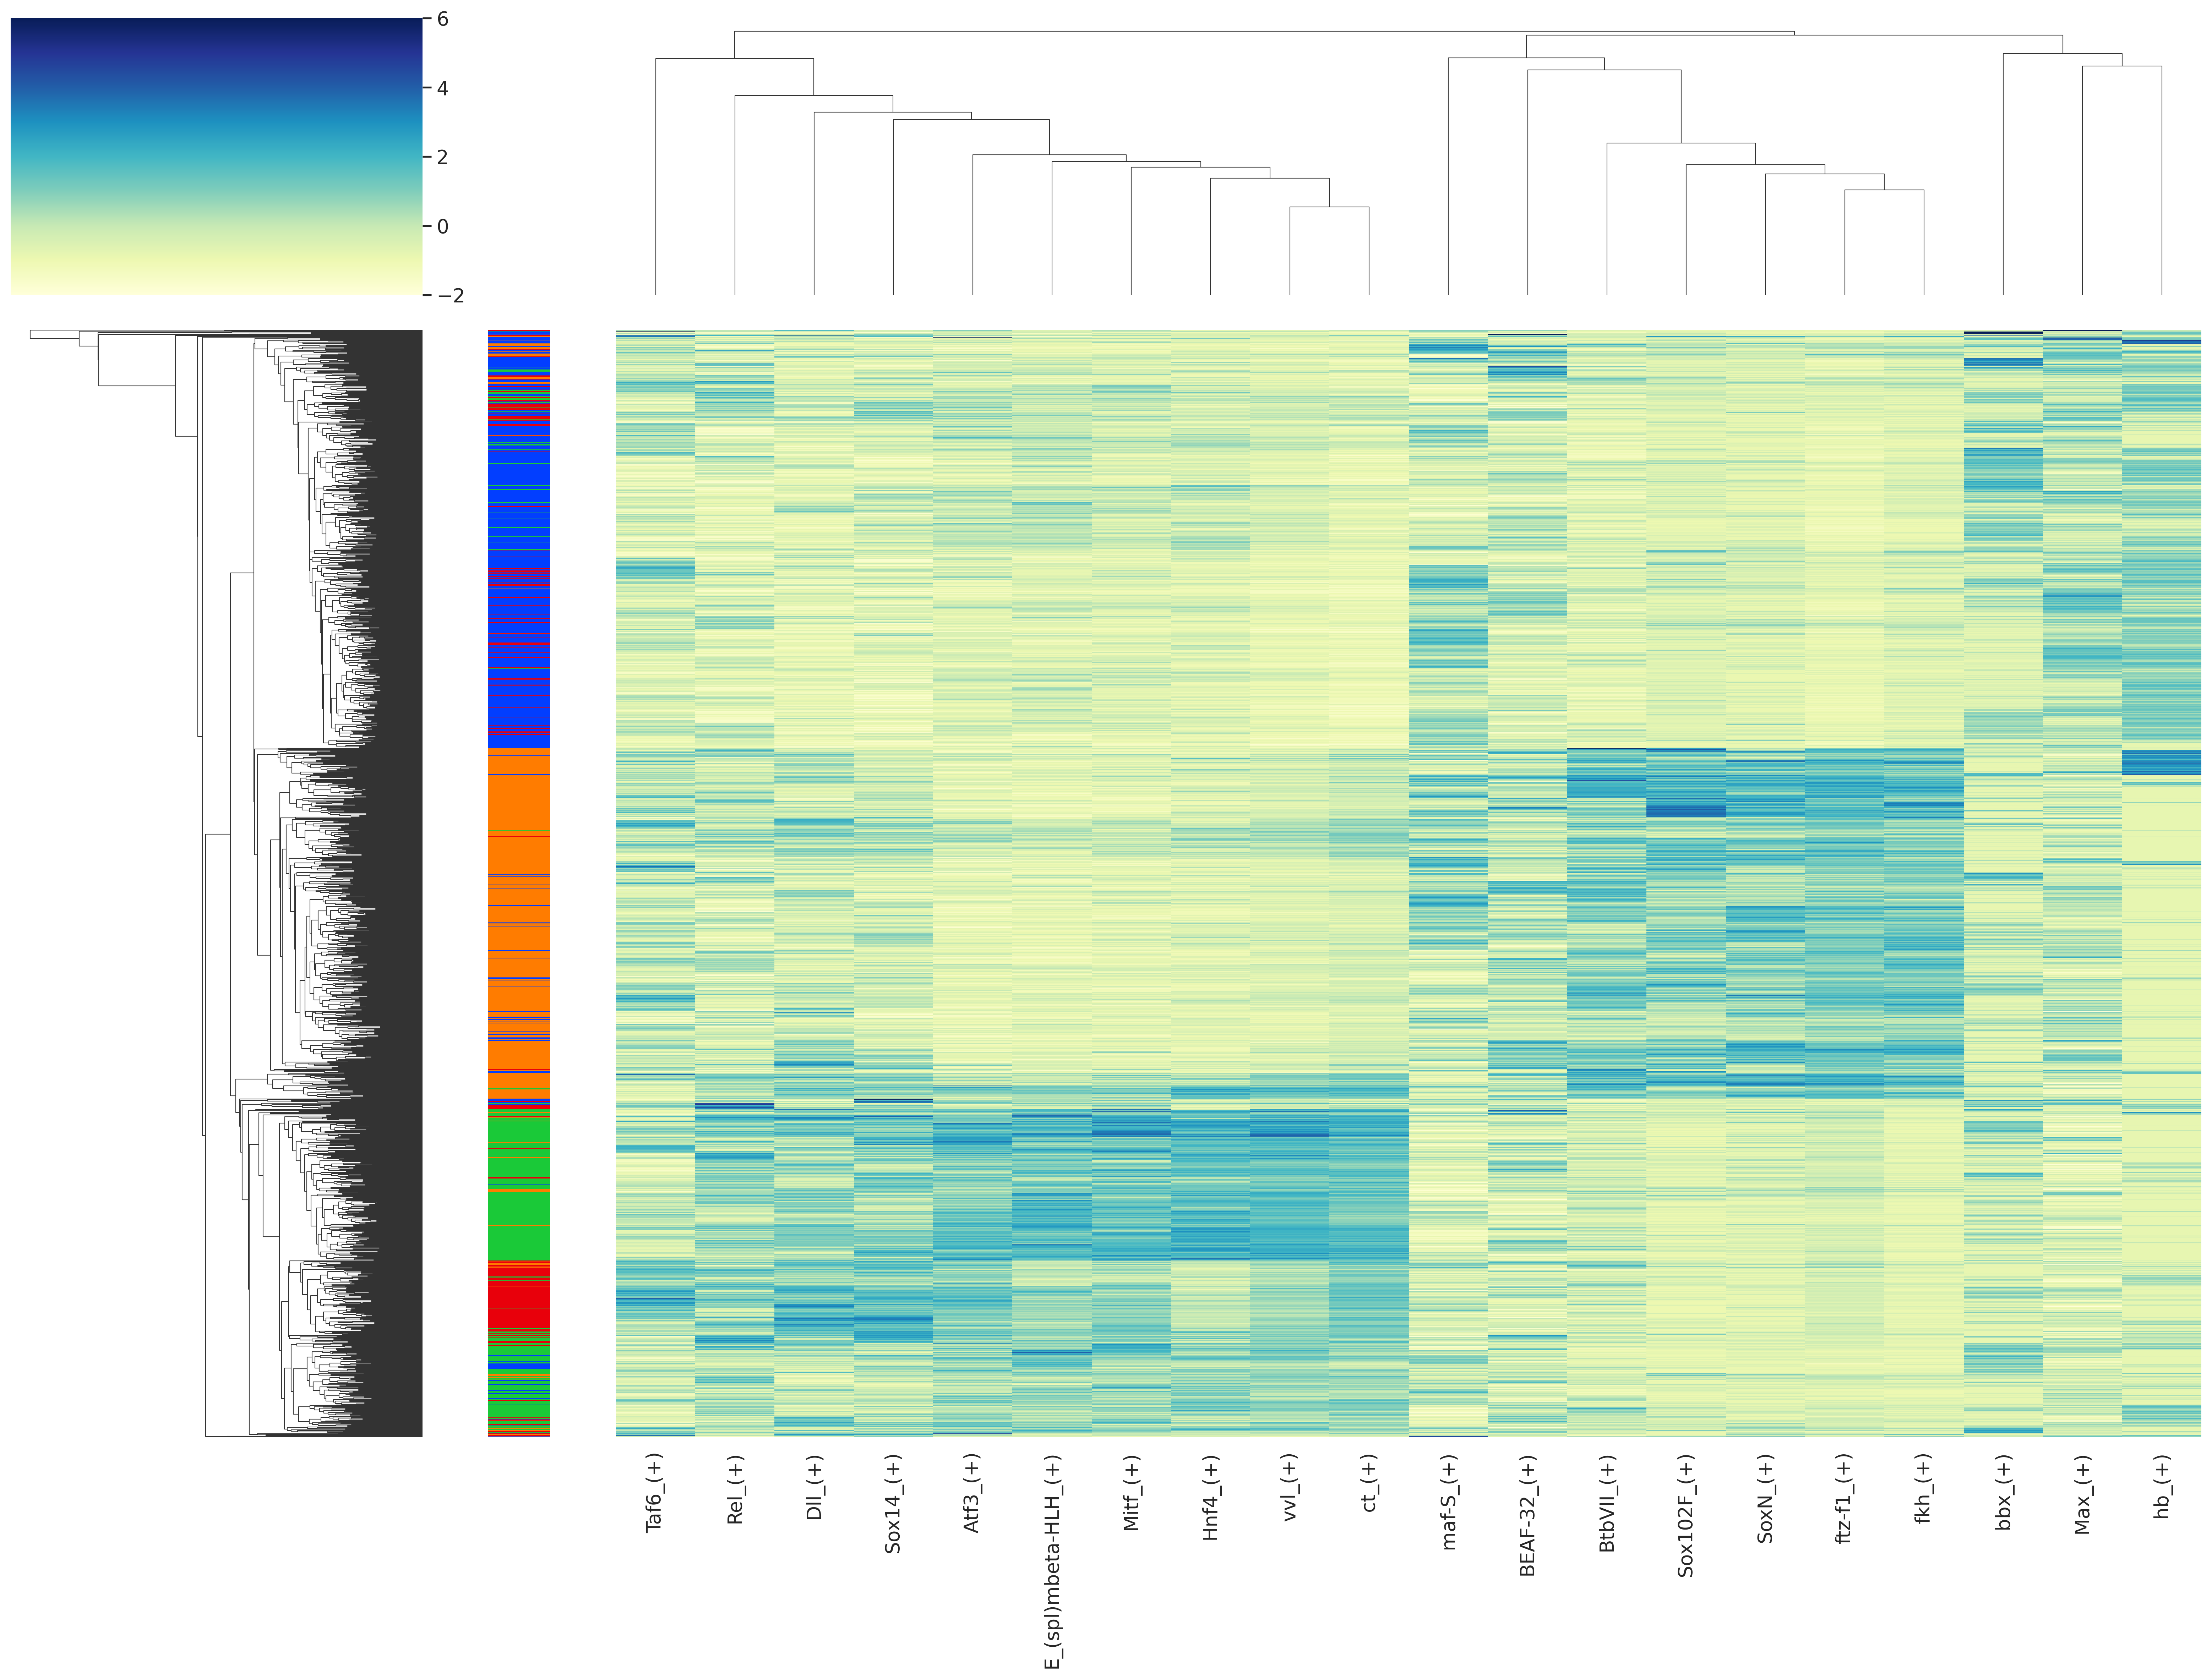

In [59]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')   

# Further exploration of modules directly from the network inference output

In [60]:
adjacencies = pd.read_csv("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/ASTROCYTE/output/control/control_adj.csv", index_col=False)

In [61]:
unique_adj_genes = set(adjacencies["TF"]).union(set(adjacencies["target"])) - set(exprMat.columns)
unique_adj_genes

{nan}

In [62]:
adjacencies

TF   target    importance
0        Tet    Eaat1  1.363932e+02
1        Tet  CG42342  1.067643e+02
2        Tet   Prosap  1.024126e+02
3        Tet      Gat  9.366166e+01
4        Tet   CG9394  7.162212e+01
...      ...      ...           ...
900781   crp    ImpE1  1.402781e-17
900782  mamo  CG31937  1.336359e-17
900783  TFAM     Elal  1.242068e-17
900784   cic  CG14402  1.221599e-17
900785  Iswi   CG5903  9.289517e-18

[900786 rows x 3 columns]

In [63]:
adjacencies = adjacencies.dropna()

In [64]:
adjacencies

TF   target    importance
0        Tet    Eaat1  1.363932e+02
1        Tet  CG42342  1.067643e+02
2        Tet   Prosap  1.024126e+02
3        Tet      Gat  9.366166e+01
4        Tet   CG9394  7.162212e+01
...      ...      ...           ...
900781   crp    ImpE1  1.402781e-17
900782  mamo  CG31937  1.336359e-17
900783  TFAM     Elal  1.242068e-17
900784   cic  CG14402  1.221599e-17
900785  Iswi   CG5903  9.289517e-18

[900713 rows x 3 columns]

In [65]:
unique_adj_genes = set(adjacencies["TF"]).union(set(adjacencies["target"])) - set(exprMat.columns)
unique_adj_genes

set()

In [66]:
exprMat.head()

NA  msps  CG6013  Dsk  CG8043  lncRNA:CR45911  \
AAACGCTAGATGGCAC-1_1  0.0   0.0     0.0  0.0     0.0             0.0   
AAAGAACTCCAAGGGA-1_1  0.0   0.0     0.0  0.0     0.0             0.0   
AAAGGGCGTGAATGTA-1_1  0.0   0.0     0.0  0.0     0.0             0.0   
AACCATGTCACGTCCT-1_1  0.0   0.0     0.0  0.0     0.0             0.0   
AACGGGAAGTGGCCTC-1_1  0.0   0.0     0.0  0.0     0.0             0.0   

                       CG42788  Atg17  CG15525   ATPsynE  ...  Mhc  \
AAACGCTAGATGGCAC-1_1  2.931833    0.0      0.0  0.000000  ...  0.0   
AAAGAACTCCAAGGGA-1_1  0.000000    0.0      0.0  2.810908  ...  0.0   
AAAGGGCGTGAATGTA-1_1  0.000000    0.0      0.0  0.000000  ...  0.0   
AACCATGTCACGTCCT-1_1  2.430336    0.0      0.0  2.430336  ...  0.0   
AACGGGAAGTGGCCTC-1_1  1.569091    0.0      0.0  1.569091  ...  0.0   

                      lncRNA:CR44855  CG14402  lncRNA:CR45461  FBti0063434  \
AAACGCTAGATGGCAC-1_1             0.0      0.0             0.0          0.0   
AAAGAACTCCAAGGGA-1_1             0.0      0.0             0.0          0.0   
AAAGGGCGTGAATGTA-1_1             0.0      0.0             0.0          0.0   
AACCATGTCACGTCCT-1_1             0.0      0.0             0.0          0.0   
AACGGGAAGTGGCCTC-1_1             0.0      0.0             0.0          0.0   

                      FBti0062808  topi  Cyp313b1  lncRNA:CR32385  FBti0060483  
AAACGCTAGATGGCAC-1_1          0.0   0.0       0.0             0.0          0.0  
AAAGAACTCCAAGGGA-1_1          0.0   0.0       0.0             0.0          0.0  
AAAGGGCGTGAATGTA-1_1          0.0   0.0       0.0             0.0          0.0  
AACCATGTCACGTCCT-1_1          0.0   0.0       0.0             0.0          0.0  
AACGGGAAGTGGCCTC-1_1          0.0   0.0       0.0             0.0          0.0  

[5 rows x 8724 columns]

In [67]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2023-05-16 16:38:33,891 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-05-16 16:38:34,025 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-05-16 16:38:41,235 - pyscenic.utils - INFO - Creating modules.


In [68]:
tf = 'lola'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

lola module 0: 1167 genes
lola module 1: 630 genes
lola module 2: 51 genes
lola module 3: 205 genes
lola module 4: 447 genes
lola module 5: 2034 genes
lola regulon: 470 genes


In [69]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'_(+)']:
        f.write("%s\n" % item)